In [43]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
# from google.colab import drive
from PIL import Image

In [3]:
base_dir = (r'C:\Users\user\Documents\Loven Capstone\dataset')
train_dir = os.path.join(base_dir, 'penyakit kopi/train')
validation_dir = os.path.join(base_dir, 'penyakit kopi/validation')

In [4]:
# train_dir = '/content/drive/MyDrive/dataset/penyakit kopi/train'
# validation_dir = '/content/drive/MyDrive/dataset/penyakit kopi/validation'

In [5]:
def load_images_from_directory(directory, width, height):
    image_data = []
    image_target = []
    classes = os.listdir(directory)
    for title in classes:
        class_dir = os.path.join(directory, title)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")
                        img = img.resize((width, height))
                        img_array = np.array(img)
                        image_data.append(img_array)
                        image_target.append(title)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(image_data), np.array(image_target) 

# def load_images_from_directory(directory, width, height):
#     image_data = []
#     image_target = []
#     classes = os.listdir(directory)
#     for title in classes:
#         class_dir = os.path.join(directory, title)
#         if os.path.isdir(class_dir):
#             for img_name in os.listdir(class_dir):
#                 img_path = os.path.join(class_dir, img_name)
#                 img = cv2.imread(img_path)
#                 if img is not None:
#                     if img.shape[-1] == 1:
#                         img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#                     else:
#                         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                     img = cv2.resize(img, (width, height))
#                     image_data.append(img)
#                     image_target.append(title)
#     return np.array(image_data), np.array(image_target)


In [6]:
train_images, train_labels = load_images_from_directory(train_dir, 224, 224)
validation_images, validation_labels = load_images_from_directory(validation_dir, 224, 224)

train_images = train_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(lb.classes_), activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

In [8]:
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/50
36/36 [==============================] - 37s 934ms/step - loss: 1.4622 - accuracy: 0.4103 - val_loss: 1.2773 - val_accuracy: 0.4850
Epoch 2/50
36/36 [==============================] - 29s 816ms/step - loss: 1.0641 - accuracy: 0.5755 - val_loss: 0.9170 - val_accuracy: 0.6625
Epoch 3/50
36/36 [==============================] - 26s 732ms/step - loss: 0.8946 - accuracy: 0.6492 - val_loss: 0.7353 - val_accuracy: 0.7500
Epoch 4/50
36/36 [==============================] - 31s 858ms/step - loss: 0.7186 - accuracy: 0.7389 - val_loss: 0.6231 - val_accuracy: 0.7925
Epoch 5/50
36/36 [==============================] - 32s 909ms/step - loss: 0.6634 - accuracy: 0.7425 - val_loss: 0.5415 - val_accuracy: 0.8250
Epoch 6/50
36/36 [==============================] - 37s 1s/step - loss: 0.5784 - accuracy: 0.7940 - val_loss: 0.4829 - val_accuracy: 0.8425
Epoch 7/50
36/36 [==============================] - 30s 843ms/step - loss: 0.5303 - accuracy: 0.8046 - val_loss: 0.4366 - val_accuracy: 0.8675
Ep

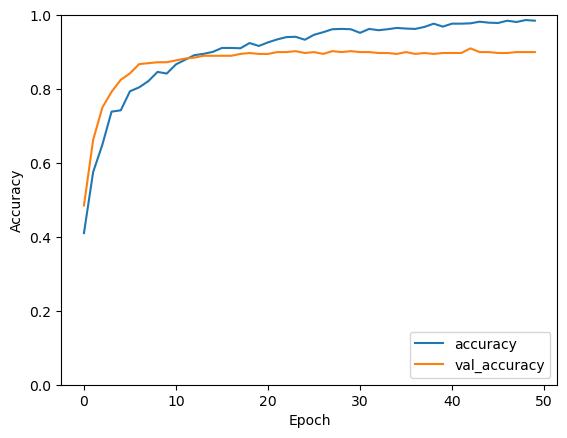

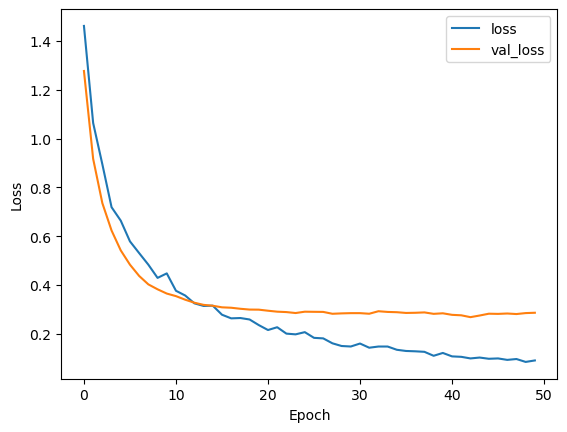

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['miner', 'nodisease', 'phoma', 'rust']
['miner', 'nodisease', 'phoma', 'rust']


In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_images, validation_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

# Predict classes
y_pred = np.argmax(model.predict(validation_images), axis=1)
y_true = np.argmax(validation_labels, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Print confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))
print('Classification Report:')
print(classification_report(y_true, y_pred))

13/13 [==============================] - 7s 499ms/step - loss: 0.2857 - accuracy: 0.9000
Loss: 0.2857
Accuracy: 90.00%
13/13 [==============================] - 7s 493ms/step
Validation Accuracy: 90.00%
Confusion Matrix:
[[104  12   4   8]
 [  1 108   5   2]
 [  0   0  94   2]
 [  4   1   1  54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       128
           1       0.89      0.93      0.91       116
           2       0.90      0.98      0.94        96
           3       0.82      0.90      0.86        60

    accuracy                           0.90       400
   macro avg       0.89      0.91      0.90       400
weighted avg       0.90      0.90      0.90       400



In [41]:
model.save('modelLovenBaru.h5')

In [45]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('modelLovenBaru.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted to TFLite and saved as 'modelLovenBaru.tflite'")

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpnls8b9fu\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpnls8b9fu\assets


Model has been converted to TFLite and saved as 'modelLovenBaru.tflite'


In [37]:
img_path = r'C:\Users\user\Documents\Loven Capstone\Penyakit Bunga dan Daun Kopi.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Define class labels
labels = ['miner', 'nodisease', 'phoma', 'rust']

# Make a prediction
prediction = model.predict(img_array)
index = np.argmax(prediction)
class_names = labels[index]

# Print prediction results
accuracy = np.max(prediction) * 100
predicted_class = class_names
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Save the model
model.save("coffeeLeaf.h5")

# # Evaluate the model on the validation set
# val_predictions = model.predict(validation_images)
# val_predictions_classes = np.argmax(val_predictions, axis=1)
# val_true_classes = np.argmax(validation_labels, axis=1)

# # Print evaluation metrics
# print("Accuracy: ", accuracy_score(val_true_classes, val_predictions_classes))
# print("Classification Report:\n", classification_report(val_true_classes, val_predictions_classes, target_names=labels))
# print("Confusion Matrix:\n", confusion_matrix(val_true_classes, val_predictions_classes))

# # Visualize the confusion matrix
# conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

1/1 [==============================] - 0s 232ms/step
Predicted Class: rust
Prediction Accuracy: 84.22%
